# Description

This code bias corrects maximum temperature values from a set of global climate model runs, and calibrating with a set of global gridded observations from Berkeley Earth. We bias-adjust a user-chosen model run from the set of '**forced**' (i.e. concatenated historical+RCP8.5) and '**natural**' Climate Model Intercomparison Project 5 (CMIP5) runs available in \*.zarr format (saved out via XXXXX.ipynb).

Bias adjustment is performed based on the methodology of [Lange (2019)](doi.org/10.5194/gmd-12-3055-2019); functions in the [cmip5_bias_adjustment.py](./cmip5_bias_adjustment.py). Accordingly, this notebook is licenced following GNU [Affero General Public License v3.0](https://www.gnu.org/licenses/agpl-3.0.en.html).

Bias-adjusted model runs are saved out into a set of data files that mimic the structure of the inputs.

# Setup

In [1]:
# import the packages we need to run this code
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import utilities as util

# import the bias-adjustment module modified from Lange (2019)
import cmip5_bias_adjustment as ba

# Bias-adjustment parameters

The user chooses a set of parameters used to guide the bias-adjustment process, including the calibration ($cal$) and adjustment ($adj$) periods.

In [2]:
# choose the environmental state variable, the metric, we are looking at
metric='TMAX'

# define the training/calibration period which will use the relationship
# between the observations and the model to guide the calibration over the
# the adjustment period
calibration_period=['1985-01-01','2015-12-31']

# define the adjustment period for the forced and natural simulations 
forced_adj_period=['1885-01-01','2050-12-31']
natural_adj_period=['1975-01-01','2005-12-31']

# define the key parameters/code options for the bias adjustment modules
# here, as our analysis is univariate for TMAX, we use those recommended for 'tas'
ba_options={
    'distribution': 'normal',
    'trend_preservation': 'additive',
        }


# Load Observations

Gridded Berkeley Earth observations are used to calibrate the CMIP5 global climate model runs.

Observations are provided [Berkeley Earth](http://berkeleyearth.org/data/) (BE), and are identical to those used in the observational analysis of this work (e.g. XXXXX.ipynb). BE daily maximum temeprature data were first downloaded by Karsten Haustein in March 2019 from the [Climate Explorer](https://climexp.knmi.nl/select.cgi?id=someone@somewhere&field=berkeley_tmax_daily) database provided by the World Meteorological Organization; regridding to the standard N96 raster was performed by K. Haustein using [CDO tools](https://code.mpimet.mpg.de/projects/cdo/) following: ```cdo remapbil,r192x145```.

In [3]:
# load the daily observed data from its path
obs_path='./data/berkeley/Berkeley_'+metric+'_land_188001_201712_daily_N96_365days_degC.nc'
obsdat=xr.open_dataset(obs_path)

# reset observed daily data time grid
timegridobs=util.get_dt64(obsdat)
obsdat['time']=timegridobs

### Define observation training data during the calibration period

The climate model data will be bias-adjusted over the calibration period ($cal$) following the relationship between each model, $x_{cal}^{sim}$, and the Berkeley Earth observations, $x_{cal}^{obs}$, during that time. Here we take the calibration period to be 1985&mdash;2015 (as defined above).

The adjustment period ($adj$) is taken to be either the entire concatenated historic/future period of record 1885&mdash;2050 in the case of forced simulations, or the last 31-years of analysis in case of natural simulations (that will make up the counterfactual, see XXXX.ipynb).

In [4]:
# subset the data between the define training period endpoints
xobscal=obsdat.sel(time=slice(calibration_period[0],calibration_period[-1]))

# find the month indices associated with the training period note these
# would identical between the model and observations b/c they use the 
# same training period, but if loaded separately we have to find separately
monidx_calperiod=xobscal.groupby('time.month').groups

# Setup load of (to-be-adjusted) CMIP5 TMAX data

### Approach

As an example of the bias-adjustment process we will load in a single paired model, forced and natural, with both scenarios to be bias-adjusted. In the whole workflow, this process is repeated for each CMIP5 model (paired and unparied) in this study. This could be done directly with this script (by replacing the input name of the model) or through some paralellization (e.g. through [dask](https://dask.org/)).

For our purposes, we illustrate the methods (and comparison with the observations in XXXX.ipynb) with a single model: **GFDL-CM3**.

### File provenance and organization

In November 2018 Karsten Haustein downloaded the CMIP5 TMAX data from the [Centre for Environmental Analysis (CEDA)](https://help.ceda.ac.uk/article/4465-cmip5-data), regridded the files onto a common N96 grid, and concatenated historical+RCP8.5 timeseries before saving out the model runs into \*.nc formats. To organize our analysis herein, Daniel Gilford added datetime64 information and reorganized the files into individual monthly \*.zarr formats in July 2021.

In [5]:
# define the example model's name
mname='GFDL-CM3'

# define the example historical and natural filepaths and names
cmip5_raw_filepath='./data/cmip5/raw_TMAX/'
forced_zarrpath=mname+'_forced/'
nat_zarrpath=mname+'_natural/'

# define the month names and month integer array
monzarr='mon{:02d}.zarr'
months=np.arange(1,13)

# define the path to save the monthly bias-adjusted data to
savepath='./data/cmip5/ba_TMAX/'

# Apply Bias Adjustment

## Forced

Bias adjustment is applied month-by-month for each model, and takes about 

In [6]:
# loop over the months
for mi in months:
    
    # load the model data by month
    filepath_in=cmip5_raw_filepath+forced_zarrpath
    mondat=util.load_zarr_local(filepath_in,monzarr.format(mi)).load()
    
    # convert to Celsius
    mondat=util.KtoC(mondat)
    
    # subset the model data over the defined calibration period
    mi_xsimcal=mondat.sel(time=slice(calibration_period[0],calibration_period[1]))
    
    # subselect the observational data (by calendar month) to enable calibration
    mi_xobscal=xobscal.isel(time=monidx_calperiod[mi]).load()
    
    # subset the model data over the defined adjustment period
    mi_xsimadj=mondat.sel(time=slice(forced_adj_period[0],forced_adj_period[1]))
    del mondat
    
    # bias adjust this calendar month of data over the full adjustment period timeseries
    # using the geospatial xarray wrapper defined in cmip5_bias_adjustment.py
    mi_xsimadj_BA=ba.xr_bias_adjust_singlemonth(mi_xobscal,mi_xsimcal,mi_xsimadj,ba_options)
    
    
    
    
    stop_here

NameError: name 'stop_here' is not defined

(array([   11699.,   647889.,  3655469., 10942500.,  9708626.,  6615809.,
         2990543.,  5457183.,  6979207.,   329129.]),
 array([-63.13768  , -51.63882  , -40.13996  , -28.641104 , -17.142246 ,
         -5.643387 ,   5.8554716,  17.35433  ,  28.85319  ,  40.352047 ,
         51.850906 ], dtype=float32),
 <BarContainer object of 10 artists>)

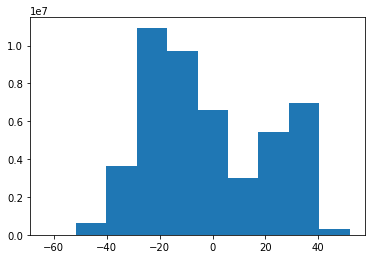

In [7]:
plt.hist(mi_xsimadj_BA.TMAX.values.ravel())

(array([1.3347000e+04, 3.6904900e+05, 1.4649080e+06, 4.8013420e+06,
        1.3861082e+07, 1.4222950e+07, 9.6699780e+06, 2.7163160e+06,
        2.0426500e+05, 1.4817000e+04]),
 array([-15.41151   , -12.239747  ,  -9.067984  ,  -5.8962207 ,
         -2.7244575 ,   0.44730568,   3.6190689 ,   6.790832  ,
          9.962595  ,  13.134358  ,  16.306122  ], dtype=float32),
 <BarContainer object of 10 artists>)

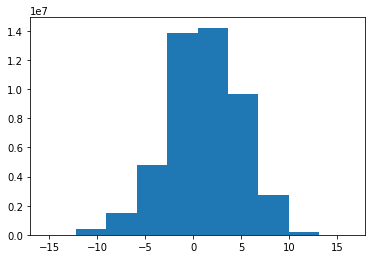

In [ ]:
plt.hist((mi_xsimadj_BA-mi_xsimadj).TMAX.values.ravel())

## Natural